# This notebook is to demonstrate the script running on EC2 that requests RDS data, trains the time series, makes forecasts, and then sends the plots to S3 to be used for the weather dashboard website. The script is run using a Docker Container and executed every week via a Linux Crontab.

In [1]:
import requests
import pandas as pd
import pymysql
from datetime import date
from datetime import datetime

###  First we connect to S3 using Boto3, and delete the previous forecasts

In [1]:
# import boto3
# session = boto3.Session(
#     aws_access_key_id='key here',
#     aws_secret_access_key='key here',
# )

# s3 = session.resource('s3')
# s3.Bucket('a bucket name').objects.all().delete()

### I’ve removed my keys from the above. Throughout the notebook I’ve commented out where Boto3 is used to send the plots to S3 in favor of plot.show() for this notebook

### Next we connect to RDS with PyMySQL, grab the data, and make it a pandas dataframe

In [3]:
#Connect to the database
connection = pymysql.connect(host='xxx.rds.amazonaws.com',
                             user='user',
                             password='a password',
                             database = 'the db',
                             cursorclass=pymysql.cursors.DictCursor)


df = pd.read_sql('select * from bulk;', connection)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# print(df[379104:]) #same as db

### Set the datetime index

In [4]:
#//////////////////////////////////////////////////
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
import math
import numpy as np


df['rain_1h'].fillna(.00000000000001, inplace=True) 
df['dt_iso'] = df['dt_iso'].apply(lambda x: x.replace("+0000 UTC",''))
df.set_index('dt_iso', inplace=True) 
df.index = pd.DatetimeIndex(df.index, dayfirst=True) 
# print(df[379000:])
# print(df)

### Train SARIMA up to last week, and make predictions for this week, in the form of a plot and max/min forecasted temperatures for each day of the week.

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

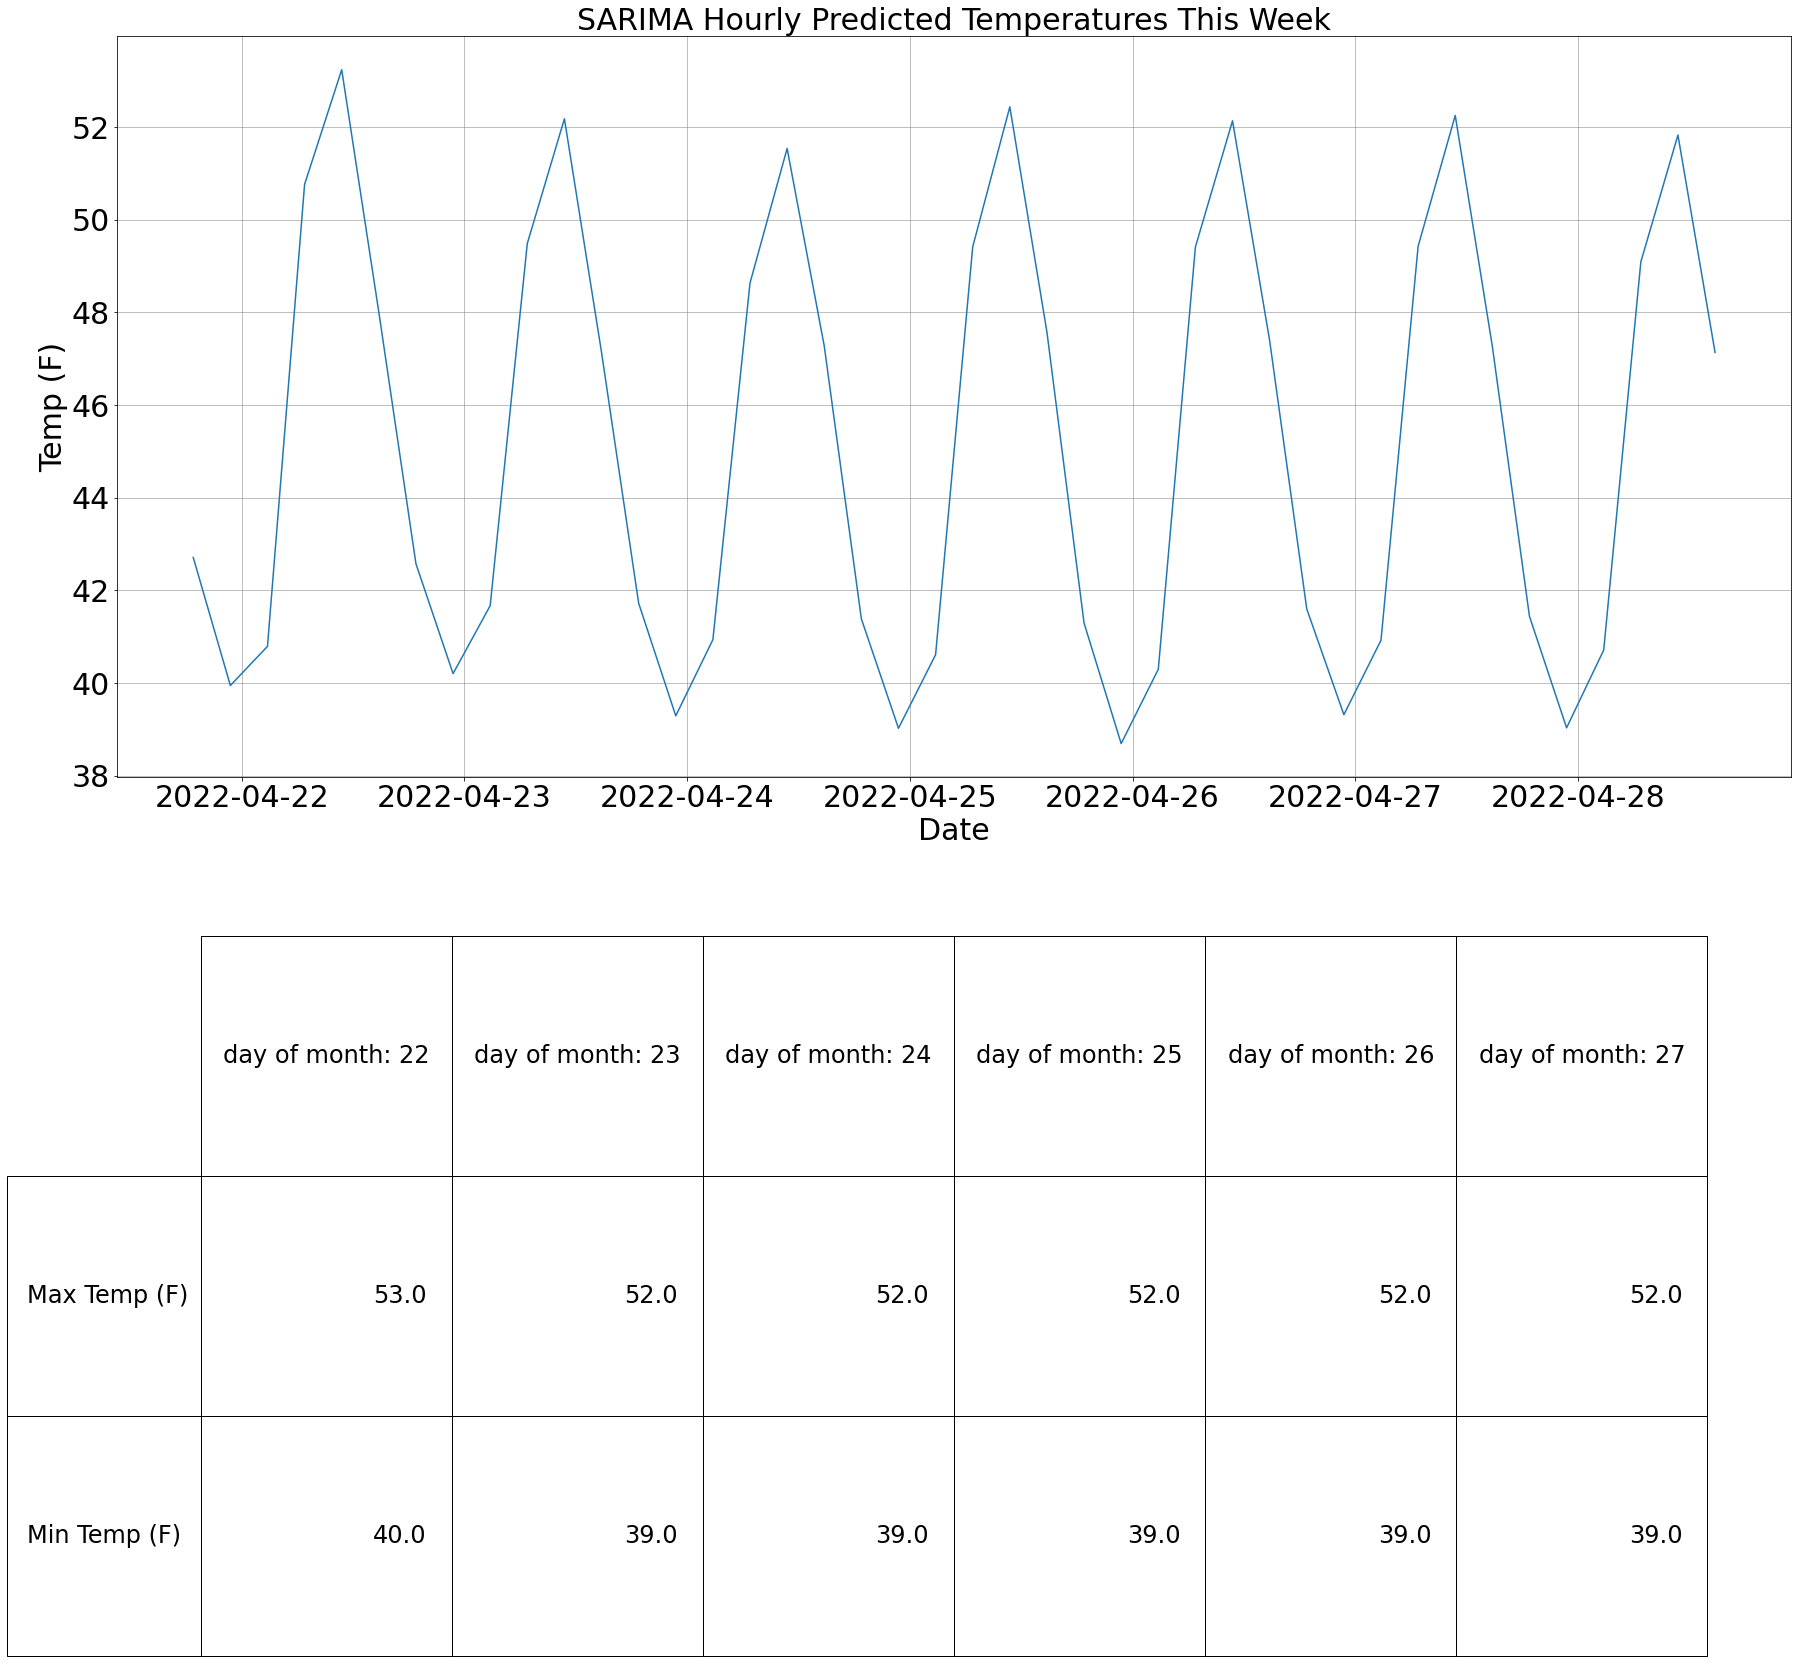

In [5]:
#Sarima Predictions
datasrma = df['temp']
datasrma.columns = ['temp']
datasrma = datasrma[::4] #every 4th hour
train = datasrma


from statsmodels.tsa.statespace.sarimax import SARIMAX
smax = SARIMAX(endog=train.tail(6570), order=(5, 0, 3), seasonal_order=(4, 1, 2, 6)).fit() #three years of training data

prediction = smax.forecast(steps=42) #168 hours in a week --> 42 (since we used datasrma[::4])


preds = pd.DataFrame(prediction) #pred


preds.columns = ['temp']
#     print(preds)



from datetime import timedelta
today_time = datetime.now()
final_time = today_time + timedelta(hours=168)
date_list = pd.DataFrame([today_time + timedelta(hours=x) for x in range(168)])[::4]
# print(date_list.dtypes)
# print(date_list.values.flatten())
preds = (preds-273.15) * 1.8 + 32 #convert kelvin to F



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 30))

ax1.plot(date_list.values, preds) #not matplotlib??
ax1.set_title('SARIMA Hourly Predicted Temperatures This Week', fontsize=30)
ax1.set_xlabel('Date', fontsize=30)
ax1.set_ylabel('Temp (F)', fontsize=30)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)


#Here we grab the max/min temps forecasted for each day and put them in a table
maxlist = []
minlist = []
daylist = []
preds.set_index(date_list.values.flatten(), inplace=True)
nowday = datetime.now().day
ilist = []
for i in [1, 2, 3, 4, 5, 6]:
    if datetime.now().month == (datetime.now()+timedelta(hours=24*i)).month: #if this month
        wheres = np.where(pd.Series(preds.index.values.flatten()).dt.day==nowday+i)[0]
        print(wheres)
        start = wheres[0]
        end = wheres[-1]+1
        maxT = round(preds[start:end].max())
        minT = round(preds[start:end].min())
        maxlist = np.append(maxlist, maxT)
        minlist = np.append(minlist, minT)
        daylist = np.append(daylist, 'day of month: ' + str(nowday+i))
        ilist = np.append(ilist, i)

#if we crossed into next month for forecast
if int(max(ilist))<6:
    j = 7-int(max(ilist)) #how many days left to forecast, to know day of next month
    print(j)
    for i in range(1, j):
        wheres = np.where(pd.Series(preds.index.values.flatten()).dt.day == i)[0]
        print(wheres)
        start = wheres[0]
        end = wheres[-1] + 1
        maxT = round(preds[start:end].max())
        minT = round(preds[start:end].min())
        maxlist = np.append(maxlist, maxT)
        minlist = np.append(minlist, minT)
        daylist = np.append(daylist, 'day of month: ' + str(i))
maxmindf = pd.DataFrame([maxlist, minlist], columns=daylist, index=['Max Temp (F)', 'Min Temp (F)'])
# print(maxmindf)

ax2.xaxis.set_visible(False)  # hide the x axis
ax2.yaxis.set_visible(False)  # hide the y axis
ax2.axis('off')
tab = ax2.table(cellText=maxmindf.values,
          rowLabels=maxmindf.index,
          colLabels=maxmindf.columns,  loc='center')
tab.scale(0.9, 20)
tab.set_fontsize(30)

# fig.savefig('SarimaPredsTable.png', bbox_inches="tight", dpi=fig.dpi)
# s3.Bucket("bucket_name").upload_file('SarimaPredsTable.png', 'SarimaPredsTable.png')
plt.show()
plt.close()

### Train VAR up to last week, and make pressure/humidity/wind speed predictions for this week, in the form of a plot.

In [6]:
#VAR predictions
#differencing
df['deltaT_d'] = df['temp'] - df.shift(24)['temp']
df['deltaP_d'] = df['pressure'] - df.shift(24)['pressure']
df['deltaH_d'] = df['humidity'] - df.shift(24)['humidity']
df['deltaW_d'] = df['wind_speed'] - df.shift(24)['wind_speed']

data1 = df[['deltaT_d', 'deltaP_d', 'deltaH_d', 'deltaW_d']]

data1 = data1.tail(8760*35)

#creating the train and validation set
train = data1


# fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
trained_model = VAR(endog=train)
model_fit = trained_model.fit(72) 



prediction = model_fit.forecast(model_fit.y, steps=168)
# print(prediction, len(prediction))


cols = data1.columns
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])
# print('pred', pred, 'pred')
for j in range(0, 4):
    for x in range(0, len(prediction)):
       pred.iloc[x][j] = prediction[x][j]



import numpy as np
pd.set_option("display.max_rows", None, "display.max_columns", None)

preds2 = pd.DataFrame(pred)


#Reverse Data Transformation on Predictions, unlogged refers to untransformed data

unlogged_T = []
for j in range(24):
    exp = df['temp'][-24 + -168 + j] + preds2['deltaT_d'].iloc[j]
    unlogged_T = np.append(unlogged_T, exp)

for j in range(168-24):
    exp = unlogged_T[j] + preds2['deltaT_d'].iloc[24+j] #last ended at 23 and j starts from 0
    unlogged_T = np.append(unlogged_T, exp)


unlogged_P = []
for j in range(24):
    exp = df['pressure'][-24 + -168 + j] + preds2['deltaP_d'].iloc[j]
    unlogged_P = np.append(unlogged_P, exp)

for j in range(168 - 24):
    exp = unlogged_P[j] + preds2['deltaP_d'].iloc[24 + j]
    unlogged_P = np.append(unlogged_P, exp)



unlogged_H = []
for j in range(24):
    exp = df['humidity'][-24 + -168 + j] + preds2['deltaH_d'].iloc[j]
    unlogged_H = np.append(unlogged_H, exp)

for j in range(168 - 24):
    exp = unlogged_H[j] + preds2['deltaH_d'].iloc[24 + j]  # last ended at 23 and j starts from 0
    unlogged_H = np.append(unlogged_H, exp)

unlogged_W = []
for j in range(24):
    exp = df['wind_speed'][-24 + -168 + j] + preds2['deltaW_d'].iloc[j]
    unlogged_W = np.append(unlogged_W, exp)

for j in range(168 - 24):
    exp = unlogged_W[j] + preds2['deltaW_d'].iloc[24 + j]  # last ended at 23 and j starts from 0
    unlogged_W = np.append(unlogged_W, exp)



date_list2 = pd.DataFrame([today_time + timedelta(hours=x) for x in range(168)])

#GoodT/P/H refers to the reverse transformed predictions.
Good_T = pd.DataFrame(unlogged_T) #was adjusted
Good_T.set_index(date_list2.values.flatten(), inplace=True)

Good_P = pd.DataFrame(unlogged_P) #was adjusted
Good_P.set_index(date_list2.values.flatten(), inplace=True)

Good_H = pd.DataFrame(unlogged_H) #was adjusted
Good_H.set_index(date_list2.values.flatten(), inplace=True)

Good_W = pd.DataFrame(unlogged_W) #was adjusted
Good_W.set_index(date_list2.values.flatten(), inplace=True)

preds2 = pd.concat([Good_T, Good_P, Good_H, Good_W], axis=1) #Good_W, , valid2w valid2ew, valid2ns Good_EW, Good_NS,
preds2.columns = ['Tpred', 'Ppred', 'Hpred', 'Wpred'] #'EW', 'NS' 'EWpred', 'NSpred' 'Wpred' , 'W'


preds2['Tpred'] = (preds2['Tpred']-273.15) * 1.8 + 32

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


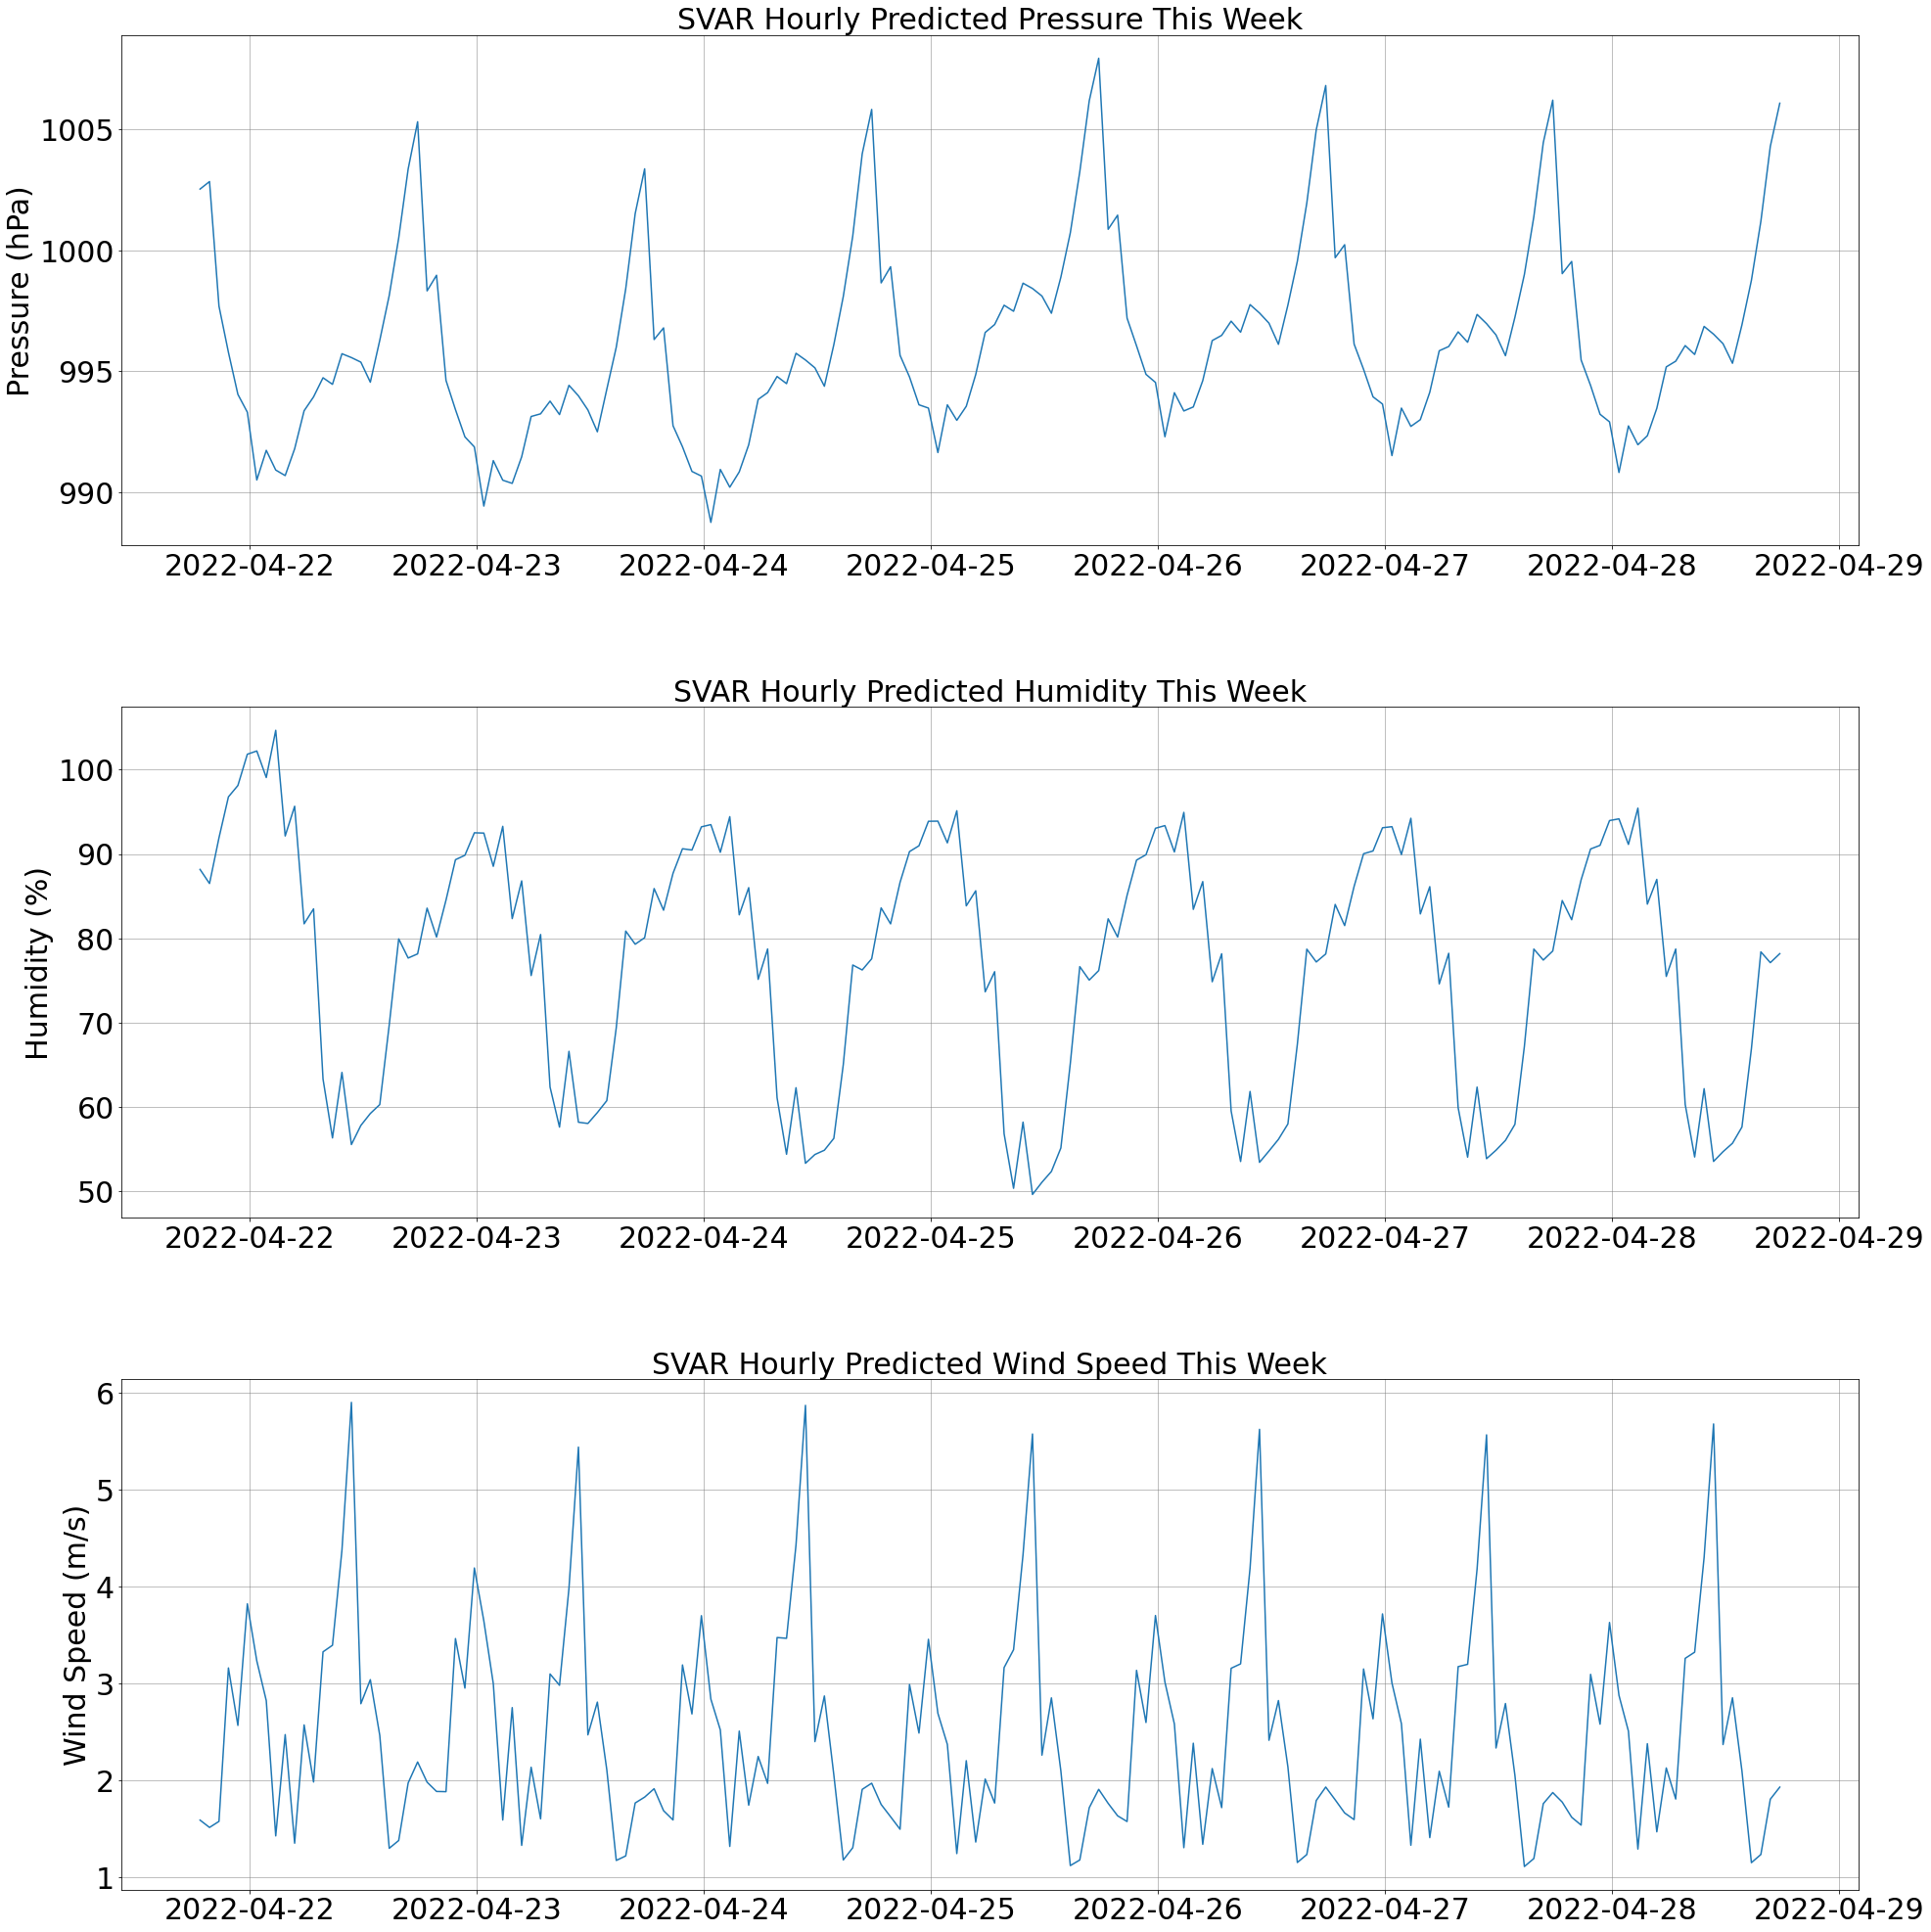

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 30))

ax1.plot(preds2.index.values, preds2['Ppred'])
ax1.set_title('SVAR Hourly Predicted Pressure This Week', fontsize=30)
ax1.set_ylabel('Pressure (hPa)', fontsize=30)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)

ax2.plot(preds2.index.values, preds2['Hpred'])
ax2.set_title('SVAR Hourly Predicted Humidity This Week', fontsize=30)
ax2.set_ylabel('Humidity (%)', fontsize=30)
ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.tick_params(axis="x", labelsize=30)
ax2.tick_params(axis="y", labelsize=30)

ax3.plot(preds2.index.values, preds2['Wpred'])
ax3.set_title('SVAR Hourly Predicted Wind Speed This Week', fontsize=30)
ax3.set_ylabel('Wind Speed (m/s)', fontsize=30)
ax3.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.tick_params(axis="x", labelsize=30)
ax3.tick_params(axis="y", labelsize=30)

fig.tight_layout(pad=10)

# fig.savefig('VarPredPHW.png', bbox_inches="tight", dpi=fig.dpi)
# s3.Bucket("bucket_name").upload_file('VarPredPHW.png', 'VarPredPHW.png')
plt.show()
plt.close()

### Plot VAR temperature predictions for this week, in the form of a plot and max/min forecasted temperatures for each day of the week.

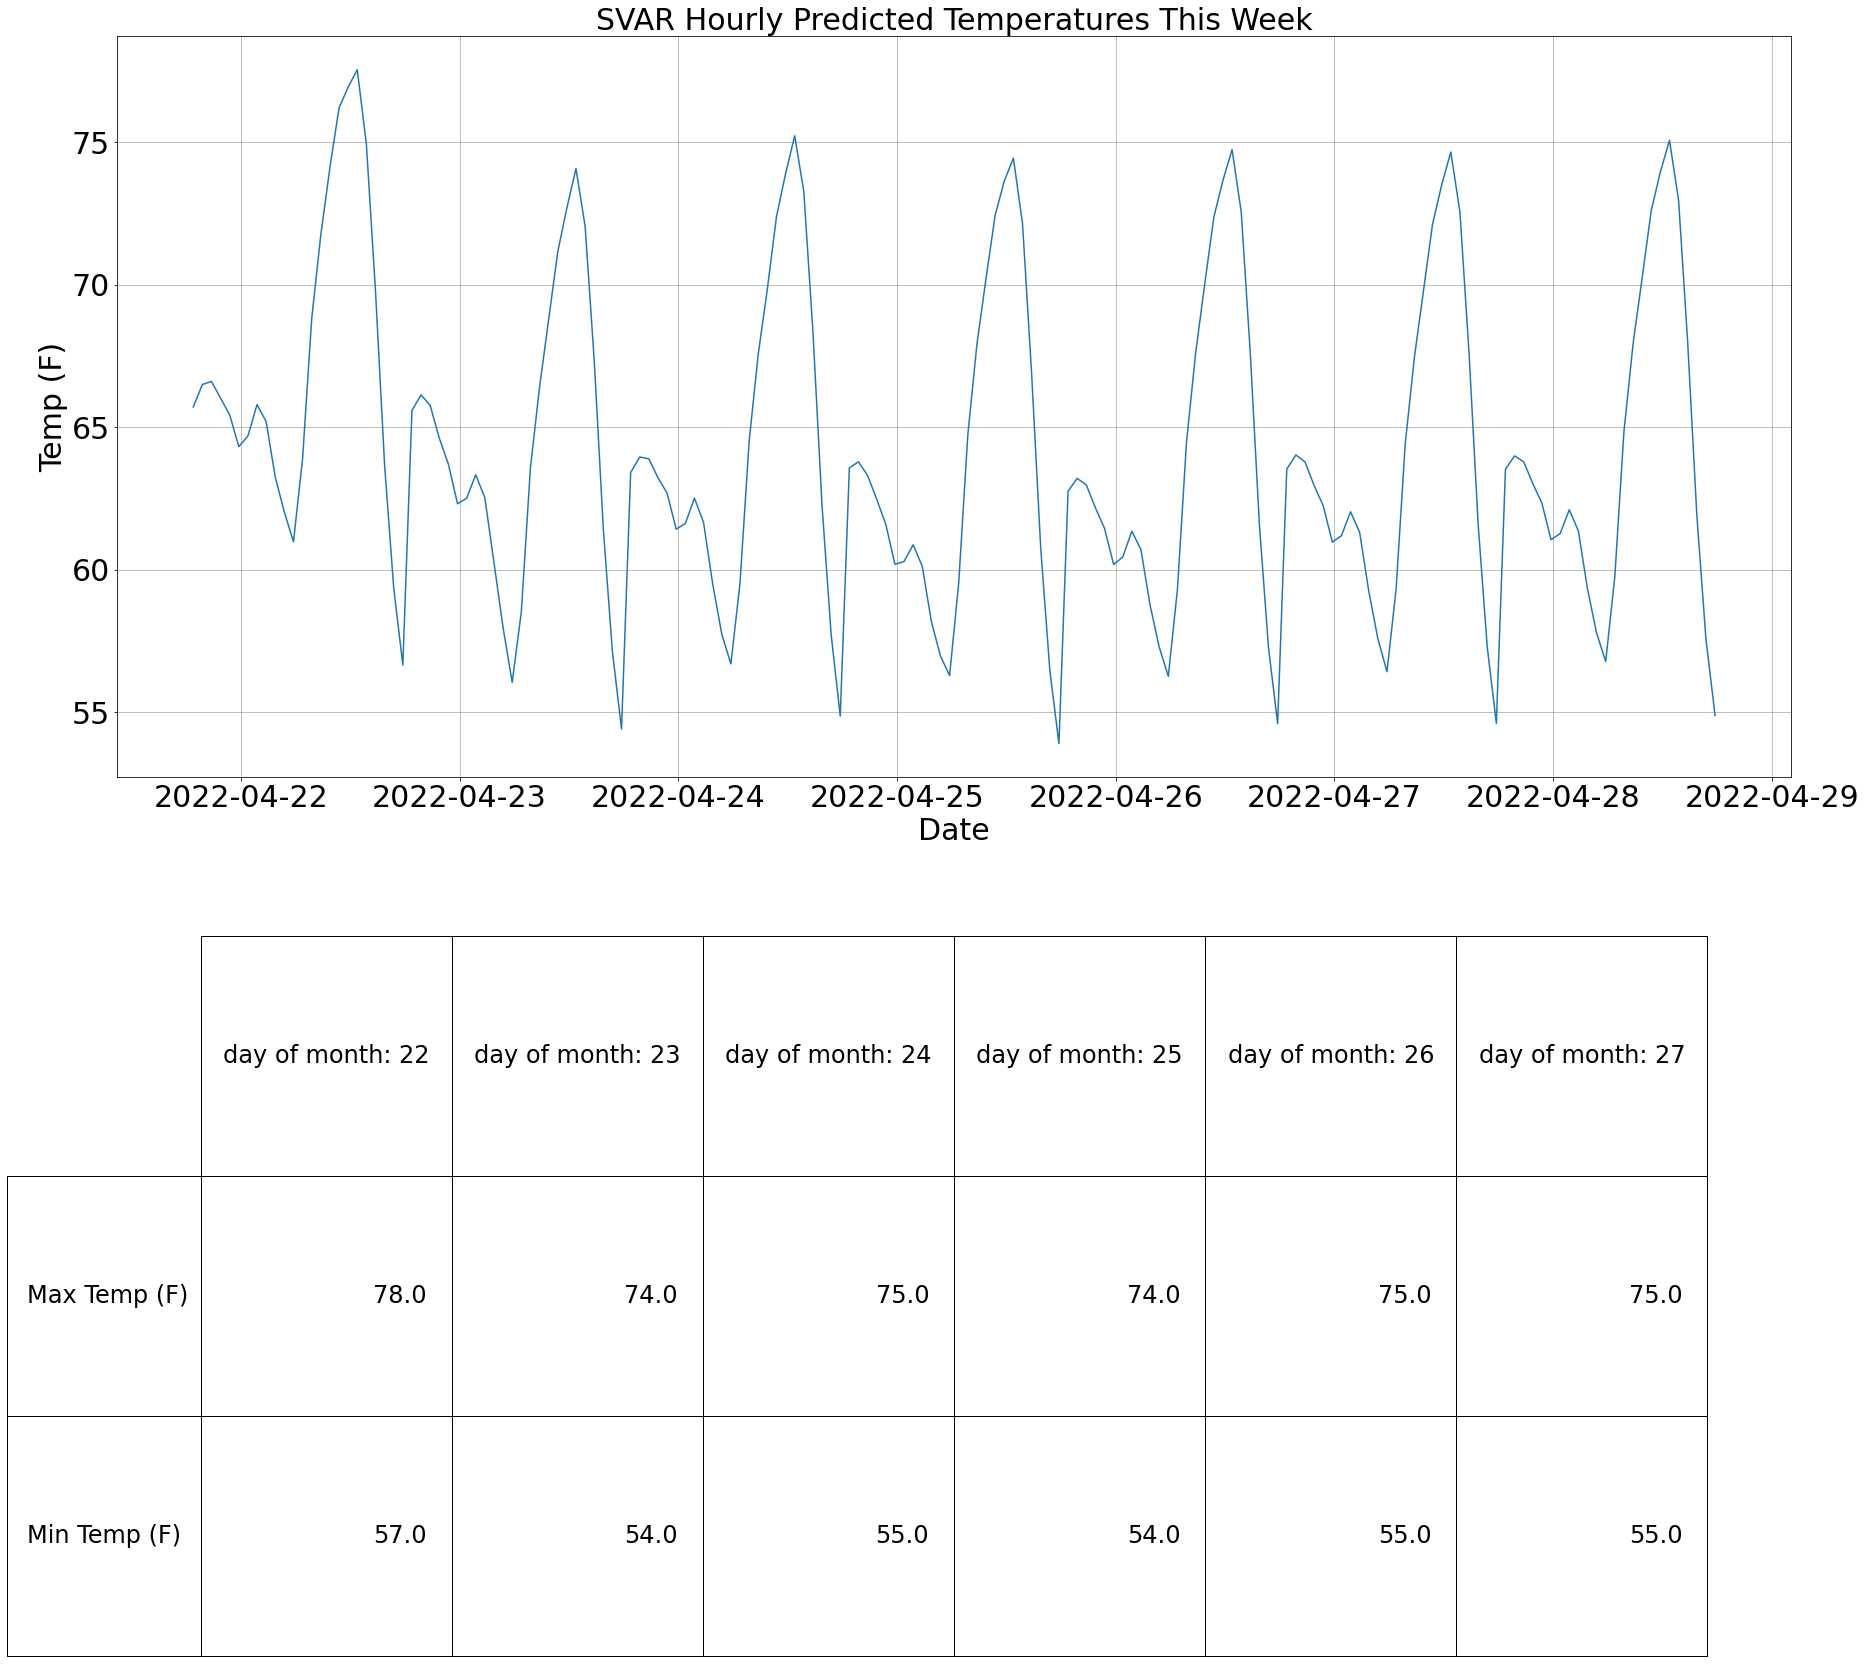

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 30))
ax1.plot(preds2.index.values, preds2['Tpred']) #not matplotlib??
ax1.set_title('SVAR Hourly Predicted Temperatures This Week', fontsize=30)
ax1.set_xlabel('Date', fontsize=30)
ax1.set_ylabel('Temp (F)', fontsize=30)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)

maxlist = []
minlist = []
daylist = []
ilist = []
nowday = datetime.now().day
for i in [1, 2, 3, 4, 5, 6]:
    if datetime.now().month == (datetime.now() + timedelta(hours=24 * i)).month:
        wheres = np.where(pd.Series(preds2['Tpred'].index.values.flatten()).dt.day==nowday+i)[0]
        start = wheres[0]
        end = wheres[-1]+1
        print(preds2['Tpred'][start:end])
        print(preds2['Tpred'][start:end].max())
        maxT = round(preds2['Tpred'][start:end].max())
        minT = round(preds2['Tpred'][start:end].min())
        maxlist = np.append(maxlist, maxT)
        minlist = np.append(minlist, minT)
        daylist = np.append(daylist, 'day of month: ' + str(nowday + i))
        ilist = np.append(ilist, i)

#if we crossed into next month for forecast
if int(max(ilist))<6:
    j = 7-int(max(ilist)) #how many days left to forecast, to know day of next month
    print(j)
    for i in range(1, j):
        wheres = np.where(pd.Series(preds2['Tpred'].index.values.flatten()).dt.day == i)[0]
        start = wheres[0]
        end = wheres[-1] + 1
        print(preds2['Tpred'][start:end])
        print(preds2['Tpred'][start:end].max())
        maxT = round(preds2['Tpred'][start:end].max())
        minT = round(preds2['Tpred'][start:end].min())
        maxlist = np.append(maxlist, maxT)
        minlist = np.append(minlist, minT)
        daylist = np.append(daylist, 'day of month: ' + str(i))

maxmindf = pd.DataFrame([maxlist, minlist], columns=daylist, index=['Max Temp (F)', 'Min Temp (F)'])
# print(maxmindf)


ax2.xaxis.set_visible(False)  # hide the x axis
ax2.yaxis.set_visible(False)  # hide the y axis
ax2.axis('off')
tab = ax2.table(cellText=maxmindf.values,
          rowLabels=maxmindf.index,
          colLabels=maxmindf.columns,  loc='center')
tab.scale(0.9, 20)
tab.set_fontsize(30)

# fig.savefig('VarPredsTable.png', bbox_inches="tight", dpi=fig.dpi)
# s3.Bucket("bucket_name").upload_file('VarPredsTable.png', 'VarPredsTable.png')
plt.show()
plt.close()

# Previous week

### All of the above is repeated for the previous week, but predictions are compared to actual temperatures, and a performance metric is given. Note that the models are only trained up to the week preceding the one we are forecasting, of course.

### Train SARIMA  up to two weeks ago, and make predictions for last week with RMSE, in the form of a plot.

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

rmse value is T:  7.31


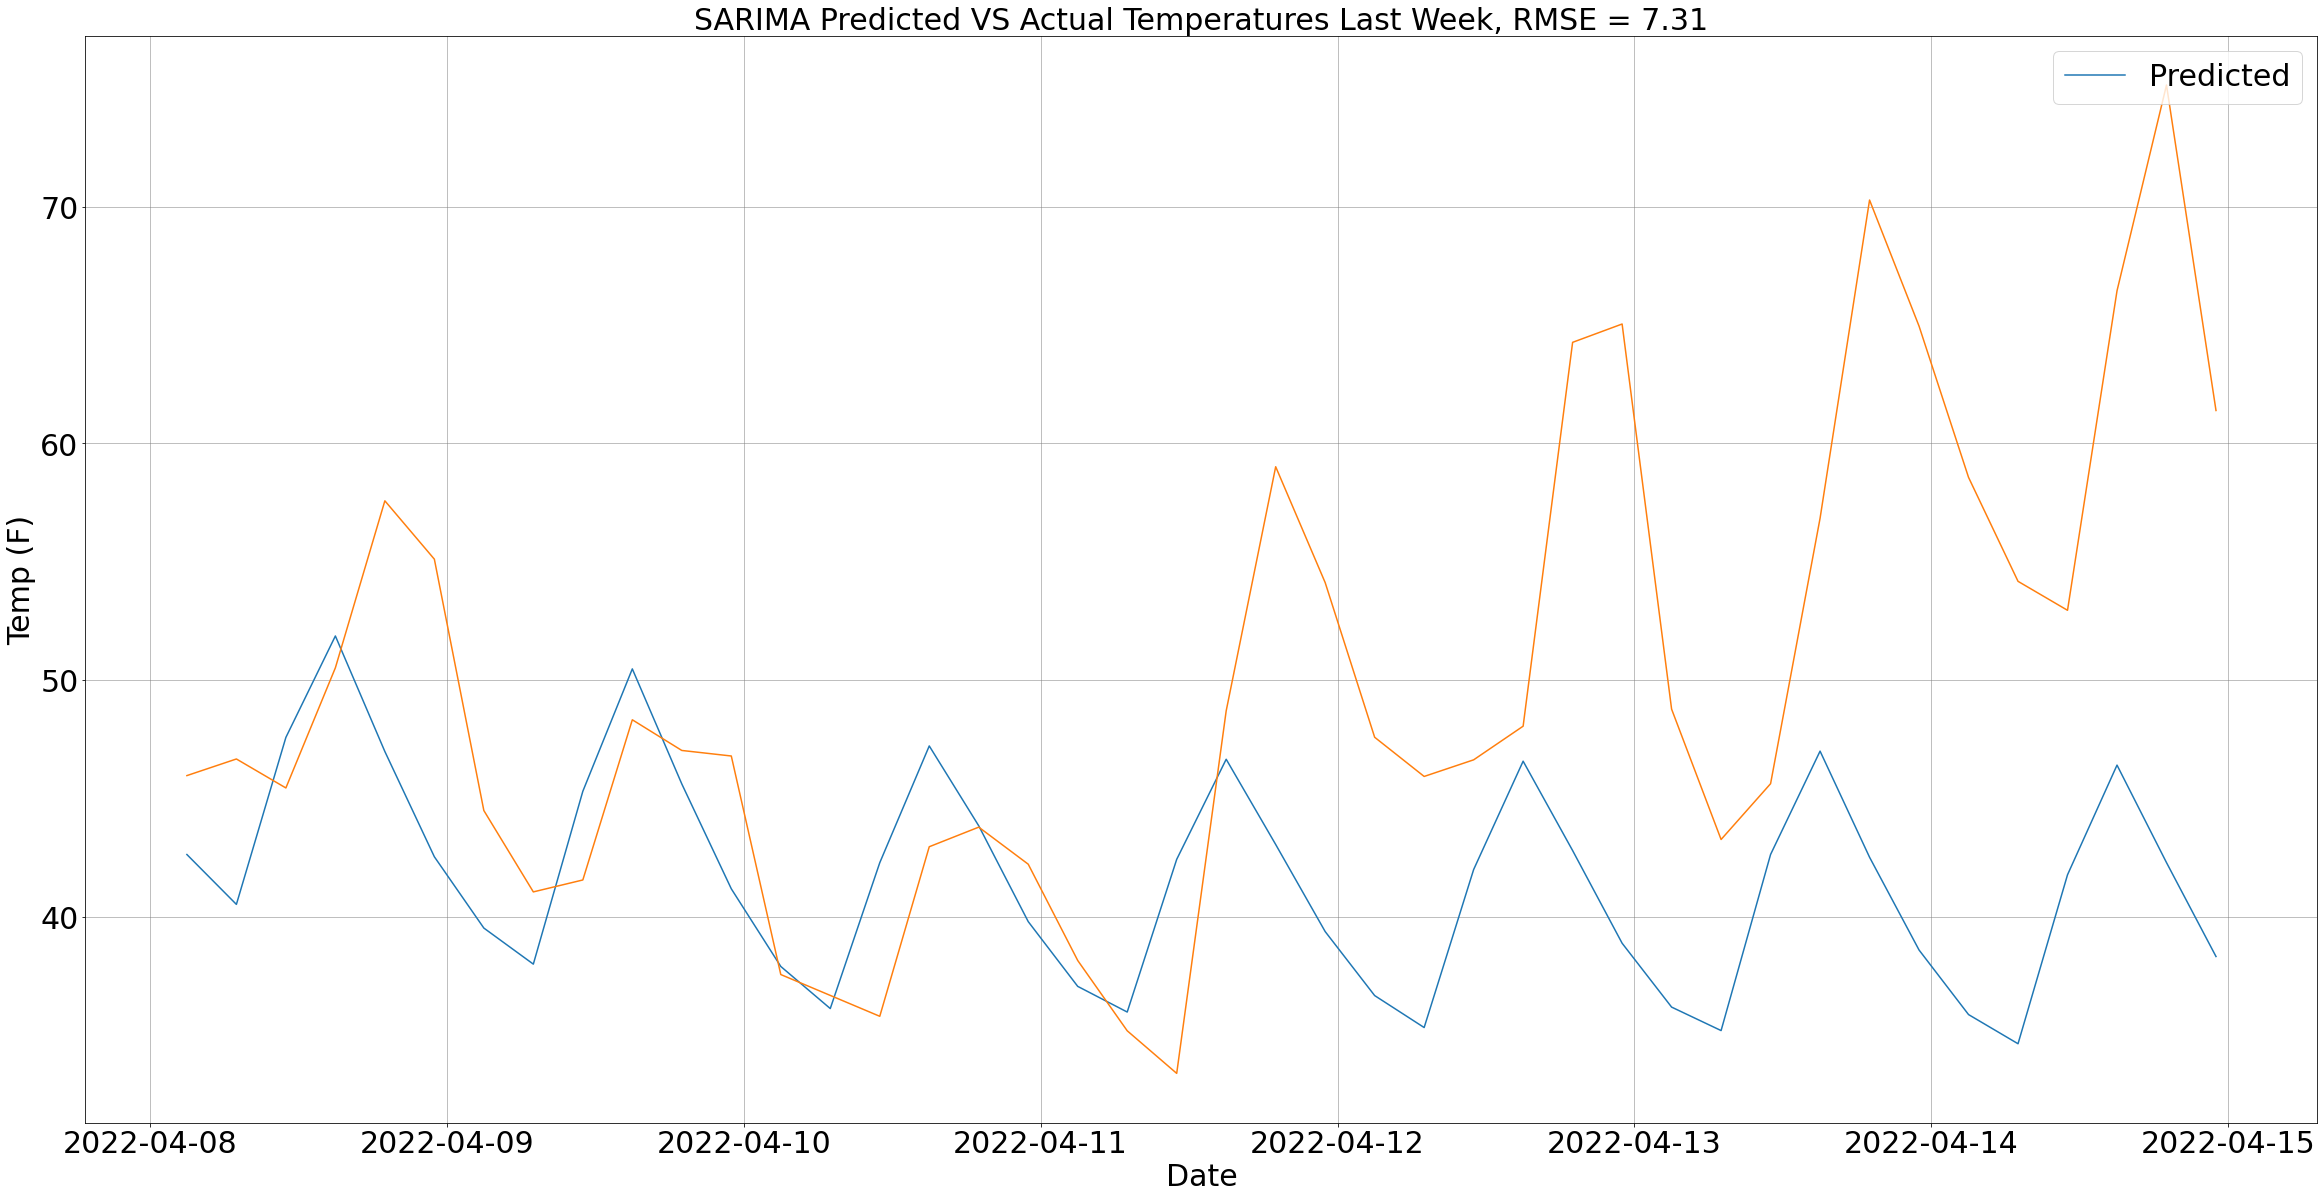

In [9]:
#/////////////////////////////////////////////////////////


#PREVIOUS WEEK
df = df[:-168]


datasrma = df['temp']
datasrma.columns = ['temp']
datasrma = datasrma[::4]
train = datasrma[:-42]
valid2t = datasrma[-42:]

from statsmodels.tsa.statespace.sarimax import SARIMAX
smax = SARIMAX(endog=train.tail(6570), order=(5, 0, 3), seasonal_order=(4, 1, 2, 6)).fit()

prediction = smax.forecast(steps=len(valid2t))



preds = pd.DataFrame(prediction) #pred
preds.set_index(valid2t.index.values, inplace=True) #dont know why didnt have to do this before but
#index of predictoins is stuck numerical. might be cus gap in time

preds.columns = ['temp']
#     print(preds)

Good_T = preds['temp'] #was adjusted
predval = pd.concat([Good_T, valid2t], axis=1)

predval.columns = ['Tpred', 'T']

# print(predval.head(25))
# print(predval.columns)

# print(Good_T)
# print(valid2)

predval['Tpred'] = (predval['Tpred']-273.15) * 1.8 + 32
predval['T'] = (predval['T']-273.15) * 1.8 + 32
sarima_rmse = round(math.sqrt(mean_squared_error(Good_T.to_numpy(), valid2t.to_numpy())), 2)
print('rmse value is T: ', sarima_rmse)


fig, ax = plt.subplots(1,1, figsize=(40, 20))
ax.plot(predval.index.values, predval['Tpred'], label='Predicted') #not matplotlib??
ax.plot(predval.index.values, predval['T']) #not matplotlib??
ax.set_title('SARIMA Predicted VS Actual Temperatures Last Week, RMSE = %s' % sarima_rmse, fontsize=30)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Temp (F)', fontsize=30)
ax.legend(loc="upper right", fontsize=30)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=30)

# fig.savefig('SarimaTempVal.png', bbox_inches="tight", dpi=fig.dpi)
# s3.Bucket("bucket_name").upload_file('SarimaTempVal.png', 'SarimaTempVal.png')
plt.show()
plt.close()

### Train Var up to two weeks ago, and make predictions for last week with RMSE, in the form of a plot.

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


rmse value is T:  5.49
rmse value is P:  5.9
rmse value is H:  17.17
rmse value is W:  1.25


C:\Users\Dave\AppData\Local\Temp/ipykernel_6716/874104822.py:140: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(predval.index.values, predval['T'], Label='Actual')


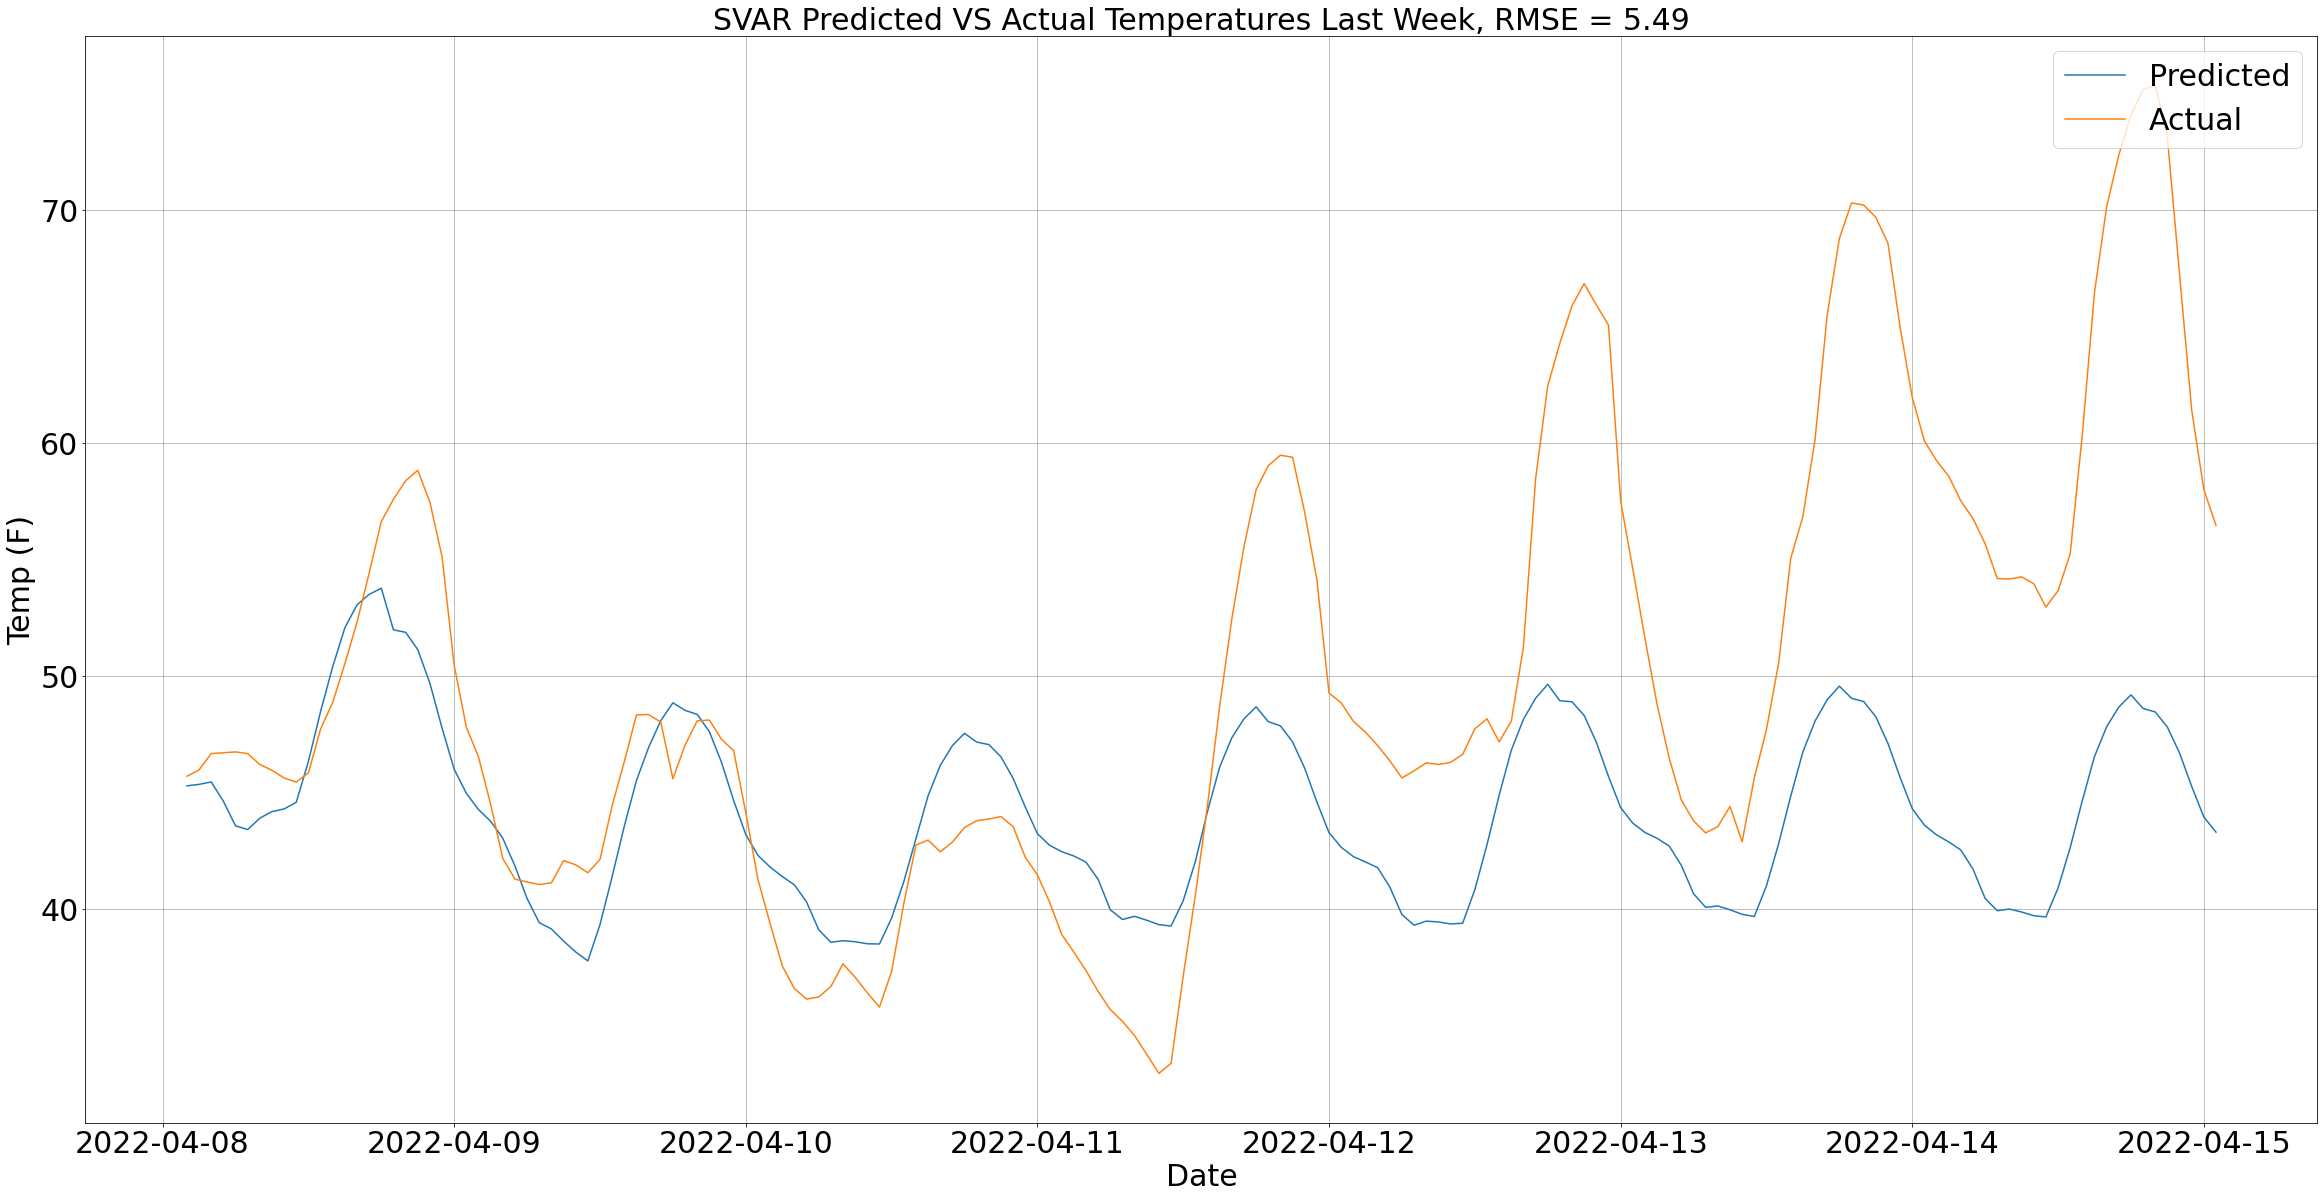

In [10]:
#differencing
df['deltaT_d2'] = df['temp'] - df.shift(24)['temp']
df['deltaP_d2'] = df['pressure'] - df.shift(24)['pressure']
df['deltaH_d2'] = df['humidity'] - df.shift(24)['humidity']
df['deltaW_d2'] = df['wind_speed'] - df.shift(24)['wind_speed']


data1 = df[['deltaT_d2', 'deltaP_d2', 'deltaH_d2', 'deltaW_d2']]

data1 = data1.tail(8760*35)

#creating the train and validation set
train = data1[:-168]
valid = data1[-168:]
valid2t = df['temp'][-168:]
valid2p = df['pressure'][-168:]
valid2h = df['humidity'][-168:]
valid2w = df['wind_speed'][-168:]


# print('valid', valid, 'valid')

# fit the model
from statsmodels.tsa.vector_ar.var_model import VAR
trained_model = VAR(endog=train)
model_fit = trained_model.fit(75) #75 lookin good



prediction = model_fit.forecast(model_fit.y, steps=len(valid))


cols = data1.columns
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])
# print('pred', pred, 'pred')
for j in range(0, 4):
    for x in range(0, len(prediction)):
       pred.iloc[x][j] = prediction[x][j]



import numpy as np
# print('pred2', pred, 'pred2')
pd.set_option("display.max_rows", None, "display.max_columns", None)

preds = pd.DataFrame(pred)





unlogged_T = []
for j in range(24):
    exp = df['temp'][-24 + -168 + j] + preds['deltaT_d2'].iloc[j] #range 24 matches with preds
    unlogged_T = np.append(unlogged_T, exp)

for j in range(168-24):
    exp = unlogged_T[j] + preds['deltaT_d2'].iloc[24+j]
    unlogged_T = np.append(unlogged_T, exp)




unlogged_P = []
for j in range(24):
    exp = df['pressure'][-24 + -168 + j] + preds['deltaP_d2'].iloc[j]
    unlogged_P = np.append(unlogged_P, exp)

for j in range(168 - 24):
    exp = unlogged_P[j] + preds['deltaP_d2'].iloc[24 + j]
    unlogged_P = np.append(unlogged_P, exp)



unlogged_H = []
for j in range(24):
    exp = df['humidity'][-24 + -168 + j] + preds['deltaH_d2'].iloc[j]
    unlogged_H = np.append(unlogged_H, exp)

for j in range(168 - 24):
    exp = unlogged_H[j] + preds['deltaH_d2'].iloc[24 + j]
    unlogged_H = np.append(unlogged_H, exp)

unlogged_W = []
for j in range(24):
    exp = df['wind_speed'][-24 + -168 + j] + preds['deltaW_d2'].iloc[j]
    unlogged_W = np.append(unlogged_W, exp)

for j in range(168 - 24):
    exp = unlogged_W[j] + preds['deltaW_d2'].iloc[24 + j]
    unlogged_W = np.append(unlogged_W, exp)





Good_T = pd.DataFrame(unlogged_T)
Good_T.set_index(valid.index.values, inplace=True)

Good_P = pd.DataFrame(unlogged_P)
Good_P.set_index(valid.index.values, inplace=True)

Good_H = pd.DataFrame(unlogged_H) #was adjusted
Good_H.set_index(valid.index.values, inplace=True)

Good_W = pd.DataFrame(unlogged_W) #was adjusted
Good_W.set_index(valid.index.values, inplace=True)





predval = pd.concat([Good_T, Good_P, Good_H, Good_W, valid2t, valid2p,
                     valid2h, valid2w], axis=1) #Good_W, , valid2w valid2ew, valid2ns Good_EW, Good_NS,
predval.columns = ['Tpred', 'Ppred', 'Hpred', 'Wpred', 'T', 'P', 'H', 'W'] #'EW', 'NS' 'EWpred', 'NSpred' 'Wpred' , 'W'

# print(predval.head(25))
# print(predval.columns)
# print(Good_T)
# print(valid2)


predval['Tpred'] = (predval['Tpred']-273.15) * 1.8 + 32
predval['T'] = (predval['T']-273.15) * 1.8 + 32
svar_rmseT = round(math.sqrt(mean_squared_error(Good_T.to_numpy(), valid2t.to_numpy())), 2)
svar_rmseP = round(math.sqrt(mean_squared_error(Good_P.to_numpy(), valid2p.to_numpy())), 2)
svar_rmseH = round(math.sqrt(mean_squared_error(Good_H.to_numpy(), valid2h.to_numpy())), 2)
svar_rmseW = round(math.sqrt(mean_squared_error(Good_W.to_numpy(), valid2w.to_numpy())), 2)



print('rmse value is T: ', svar_rmseT)
print('rmse value is P: ', svar_rmseP)
print('rmse value is H: ', svar_rmseH)
print('rmse value is W: ', svar_rmseW)

fig, ax = plt.subplots(1,1, figsize=(40, 20))
ax.plot(predval.index.values, predval['Tpred'], label='Predicted')
ax.plot(predval.index.values, predval['T'], Label='Actual')
ax.set_title('SVAR Predicted VS Actual Temperatures Last Week, RMSE = %s' % svar_rmseT, fontsize=30)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Temp (F)', fontsize=30)
ax.legend(loc="upper right", fontsize=30)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=30)



# fig.savefig('VarTempVal.png', bbox_inches="tight", dpi=fig.dpi)
# s3.Bucket("bucket_name").upload_file('VarTempVal.png', 'VarTempVal.png')
plt.show()
plt.close()

### Pressure/humidity/wind speed predictions for last week, in the form of a plot, with RMSE.

C:\Users\Dave\AppData\Local\Temp/ipykernel_6716/2679843936.py:3: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax1.plot(predval.index.values, predval['P'], Label='Actual')
C:\Users\Dave\AppData\Local\Temp/ipykernel_6716/2679843936.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.plot(predval.index.values, predval['H'], Label='Actual')
C:\Users\Dave\AppData\Local\Temp/ipykernel_6716/2679843936.py:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax3.plot(predval.index.values, predval['W'], Label='Actual')


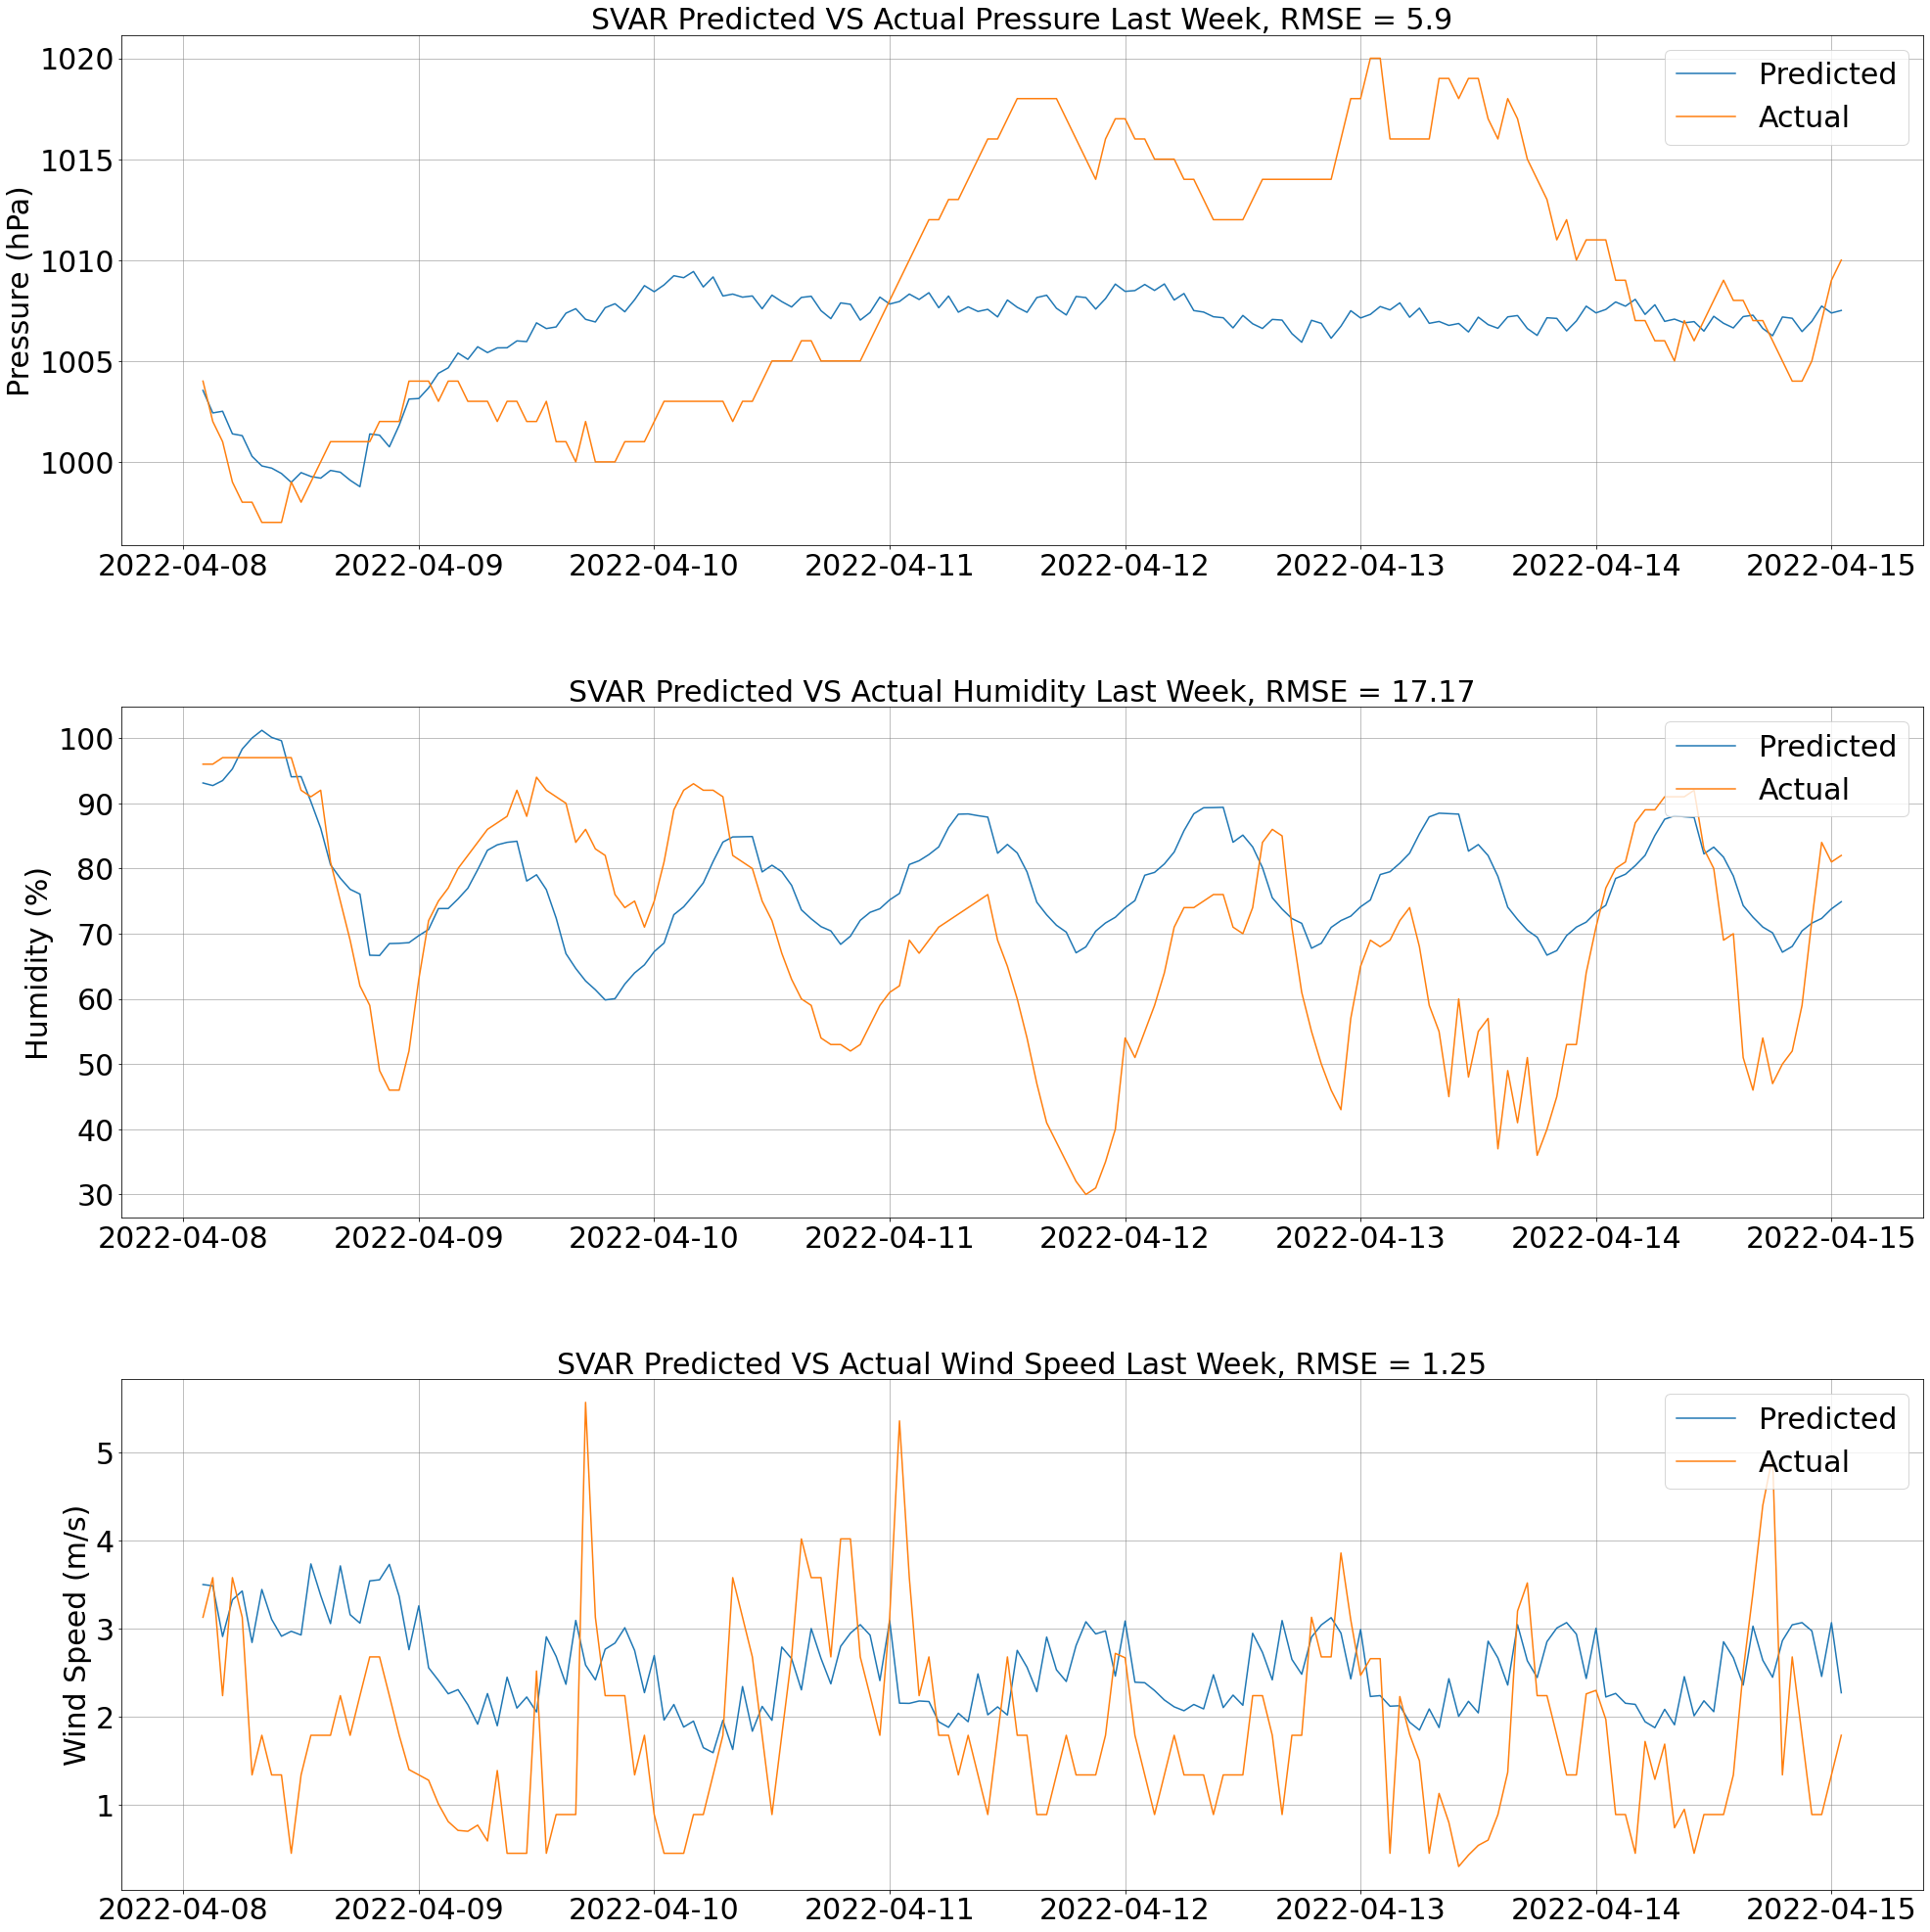

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 30))
ax1.plot(predval.index.values, predval['Ppred'], label='Predicted')
ax1.plot(predval.index.values, predval['P'], Label='Actual')
ax1.set_title('SVAR Predicted VS Actual Pressure Last Week, RMSE = %s' % svar_rmseP, fontsize=30)
ax1.set_ylabel('Pressure (hPa)', fontsize=30)
ax1.legend(loc="upper right", fontsize=30)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
ax1.tick_params(axis="x", labelsize=30)
ax1.tick_params(axis="y", labelsize=30)




ax2.plot(predval.index.values, predval['Hpred'], label='Predicted')
ax2.plot(predval.index.values, predval['H'], Label='Actual')
ax2.set_title('SVAR Predicted VS Actual Humidity Last Week, RMSE = %s' % svar_rmseH, fontsize=30)
ax2.set_ylabel('Humidity (%)', fontsize=30)
ax2.legend(loc="upper right", fontsize=30)
ax2.grid(color='gray', linestyle='-', linewidth=0.5)
ax2.tick_params(axis="x", labelsize=30)
ax2.tick_params(axis="y", labelsize=30)

#

ax3.plot(predval.index.values, predval['Wpred'], label='Predicted')
ax3.plot(predval.index.values, predval['W'], Label='Actual')
ax3.set_title('SVAR Predicted VS Actual Wind Speed Last Week, RMSE = %s' % svar_rmseW, fontsize=30)
ax3.set_ylabel('Wind Speed (m/s)', fontsize=30)

ax3.legend(loc="upper right", fontsize=30)
ax3.grid(color='gray', linestyle='-', linewidth=0.5)
ax3.tick_params(axis="x", labelsize=30)
ax3.tick_params(axis="y", labelsize=30)

fig.tight_layout(pad=10)

# fig.savefig('VarValPHW.png', bbox_inches="tight", dpi=fig.dpi)
# s3.Bucket("bucket_name").upload_file('VarValPHW.png', 'VarValPHW.png')
plt.show()
plt.close()
#/////////////////////////////////////////////////////////